# Calculate distances and find neighbors

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import poligrain as plg

## Point-to-point distances

### Get PWS dataset

In [2]:
!curl -OL https://github.com/OpenSenseAction/training_school_opensene_2023/raw/main/data/pws/data_PWS_netCDF_AMS_float.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 10.7M  100 10.7M    0     0  3921k      0  0:00:02  0:00:02 --:--:-- 7078k


In [3]:
ds_pws = xr.open_dataset("data_PWS_netCDF_AMS_float.nc")

# fix some issues with this dataset
ds_pws["time"] = pd.to_datetime(ds_pws.time.data, unit="s")
ds_pws["lon"] = ("id", ds_pws.lon.data)
ds_pws["lat"] = ("id", ds_pws.lat.data)

### Project cooridnates from lon-lat to UTM zone for Europe

Info on the UTM zone 32N projection `'EPSG:25832'` that is used can be found [here](https://epsg.io/25832#google_vignette)

Note that `plg.spatial.project_coordinates` can also use a different source coordinate system, but its default is WGS 84 (lon and lat in degrees), which is `'EPSG:4326'` 

In [4]:
ds_pws.coords["x"], ds_pws.coords["y"] = plg.spatial.project_point_coordinates(
    ds_pws.lon, ds_pws.lat, "EPSG:25832"
)

In [5]:
ds_pws

<xarray.Dataset>
Dimensions:    (time: 219168, id: 134)
Coordinates:
  * time       (time) datetime64[ns] 2016-05-01T00:05:00 ... 2018-06-01
  * id         (id) <U6 'ams1' 'ams2' 'ams3' ... 'ams132' 'ams133' 'ams134'
    elevation  (id) <U3 ...
    lat        (id) float64 52.31 52.3 52.31 52.35 ... 52.31 52.43 52.3 52.26
    lon        (id) float64 4.671 4.675 4.677 4.678 ... 5.032 5.036 5.041 5.045
    x          (id) float64 2.049e+05 2.052e+05 ... 2.301e+05 2.301e+05
    y          (id) float64 5.804e+06 5.803e+06 ... 5.802e+06 5.798e+06
Data variables:
    rainfall   (id, time) float64 ...
Attributes:
    title:         PWS data from Amsterdam
    institution:   Wageningen University and Research, Department of Environm...
    history:       Test Version 0.1
    references:    https://doi.org/10.1029/2019GL083731
    date_created:  2022-10-18 10:32:00
    Conventions:   OPENSENSE V0
    location:      Amsterdam Metropolitan Area
    source:        Netamo
    comment:

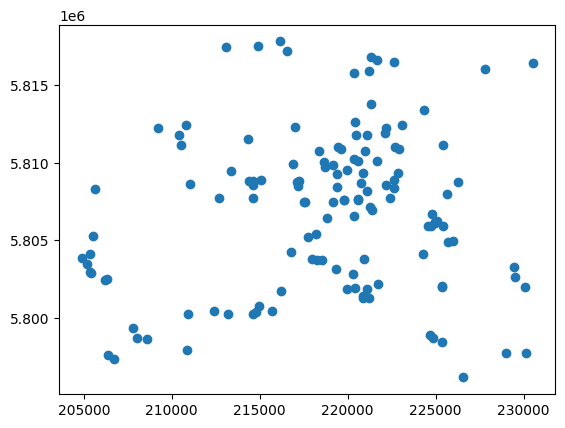

In [6]:
plt.scatter(ds_pws.x, ds_pws.y);

### Calculate distance matrix

In [65]:
distance_matrix = plg.spatial.calc_point_to_point_distances(
    ds_pws,
    ds_pws,
    max_distance=1000,
    # ds_pws.isel(id=slice(50, 80)), ds_pws.isel(id=slice(1, 40)),
)

In [75]:
distance_matrix

Format,coo
Data Type,float64
Shape,"(134, 134)"
nnz,398
Density,0.022165292938293606
Read-only,True
Size,6.2K
Storage ratio,0.04


CPU times: user 22.6 ms, sys: 3.25 ms, total: 25.9 ms
Wall time: 23.1 ms


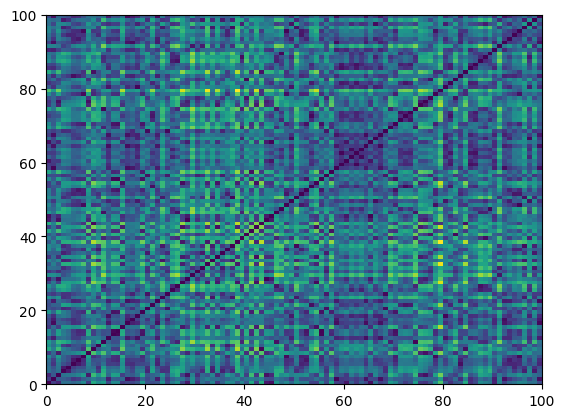

In [64]:
%%time

import scipy

N = 100
x = np.random.rand(N)
y = np.random.rand(N)

distance_matrix = scipy.spatial.distance_matrix(list(zip(x, y)), list(zip(x, y)))
plt.pcolormesh(distance_matrix);

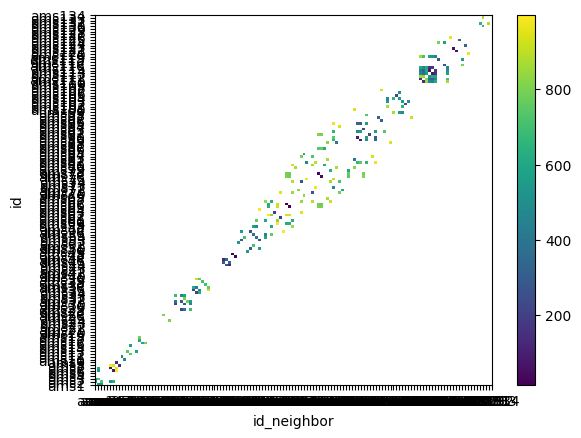

In [103]:
distance_matrix.where(distance_matrix > 0).plot()

In [105]:
distance_matrix.data.todense()[distance_matrix.data.todense() < 100]

array([0., 0., 0., ..., 0., 0., 0.])

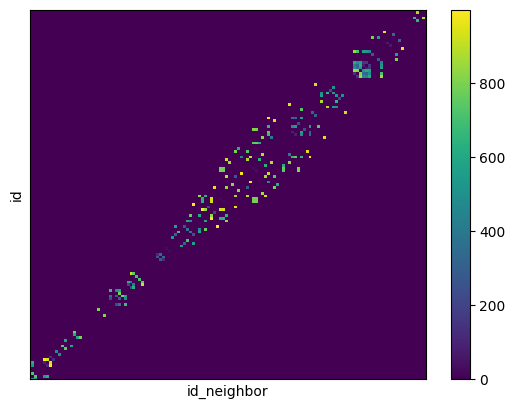

In [77]:
distance_matrix.plot()
plt.xticks([])
plt.yticks([]);

(array([14., 12., 18., 20., 24., 36., 34., 38., 36., 32.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([1.00000e-02, 1.00010e+02, 2.00010e+02, 3.00010e+02, 4.00010e+02,
        5.00010e+02, 6.00010e+02, 7.00010e+02, 8.00010e+02, 9.00010e+02,
        1.00001e+03, 1.10001e+03, 1.20001e+03, 1.30001e+03, 1.40001e+03,
        1.50001e+03, 1.60001e+03, 1.70001e+03, 1.80001e+03, 1.90001e+03,
        2.00001e+03, 2.10001e+03, 2.20001e+03, 2.30001e+03, 2.40001e+03,
        2.50001e+03, 2.60001e+03, 2.70001e+03, 2.80001e+03, 2.90001e+03,
        3.00001e+03, 3.10001e+03, 3.20001e+03, 3.30001e+03, 3.40001e+03,
        3.50001e+03, 3.60001e+03, 3.70001e+03, 3.80001e+03, 3.90001e+03,
        4.00001e+03, 4.10001e+03, 4.20001e+03, 4.30001e+03, 4.40001e+03,
        4.50001e+03, 4.60001e+03, 4.70001e+03, 4.80001e+03, 4.90

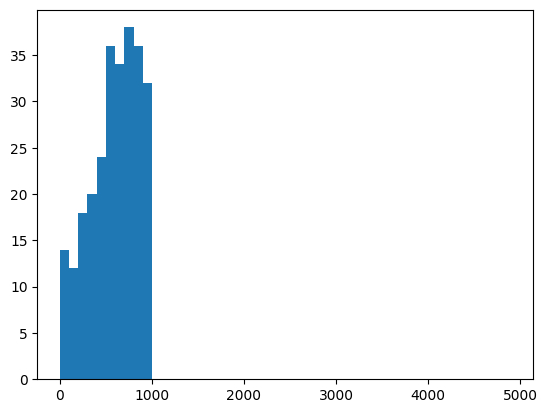

In [86]:
distance_matrix.plot.hist(bins=np.arange(0.01, 5000, 100))

In [43]:
distance_matrix.sel(id="ams2", id_neighbor=["ams1", "ams5", "ams34"])

<xarray.DataArray (id_neighbor: 3)>
array([ 518.79828487, 1857.1349428 , 9980.37990317])
Coordinates:
    id           <U6 'ams2'
  * id_neighbor  (id_neighbor) <U6 'ams1' 'ams5' 'ams34'

### Select a PWS and plot distance of neighbors

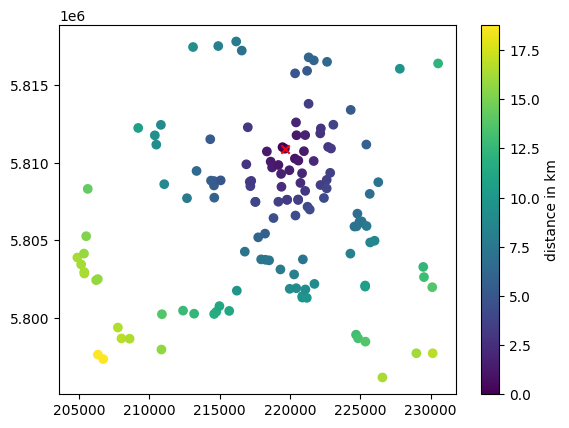

In [44]:
pws_id = "ams63"

sc = plt.scatter(ds_pws.x, ds_pws.y, c=distance_matrix.sel(id=pws_id) / 1e3)
plt.scatter(ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, c="r", marker="x")
plt.colorbar(sc, label="distance in km");

### Select neighbors within certain range

In [12]:
pws_id = "ams63"

max_distance = 3e3  # this is in meteres

distances = distance_matrix.sel(id=pws_id)
selected_neighbor_ids = ds_pws.id.data[distances < max_distance]
selected_neighbor_ids

array(['ams41', 'ams42', 'ams51', 'ams54', 'ams55', 'ams58', 'ams60',
       'ams61', 'ams62', 'ams63', 'ams67', 'ams69', 'ams70', 'ams71',
       'ams74', 'ams78', 'ams80', 'ams83', 'ams84', 'ams94', 'ams96',
       'ams97'], dtype='<U6')

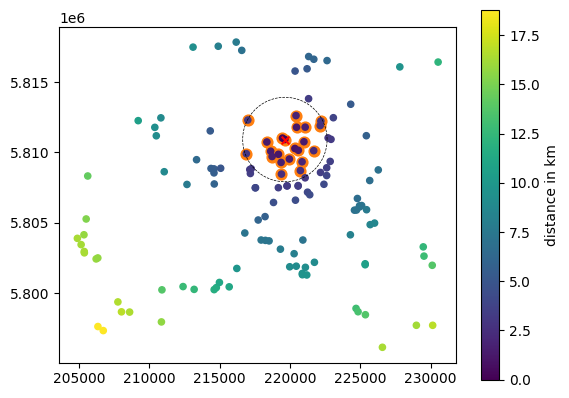

In [13]:
fig, ax = plt.subplots()
ax.scatter(
    ds_pws.x.sel(id=selected_neighbor_ids),
    ds_pws.y.sel(id=selected_neighbor_ids),
    c="C1",
    s=60,
)
sc = ax.scatter(ds_pws.x, ds_pws.y, c=distance_matrix.sel(id=pws_id) / 1e3, s=20)
ax.scatter(ds_pws.sel(id=pws_id).x, ds_pws.sel(id=pws_id).y, c="r", s=30, marker="x")
plt.colorbar(sc, label="distance in km")
ax.set_aspect("equal")

# Plot a circel with max_distance to see if the selections fits
an = np.linspace(0, 2 * np.pi, 100)
ax.plot(
    ds_pws.x.sel(id=pws_id).data + max_distance * np.cos(an),
    ds_pws.y.sel(id=pws_id).data + max_distance * np.sin(an),
    color="k",
    linestyle="--",
    linewidth=0.5,
);